## Amazon Fine Food Reviews Analysis

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454
Number of users: 256,059
Number of products: 74,258
Timespan: Oct 1999 - Oct 2012
Number of Attributes/Columns in data: 10

#### Attribute Information:

    1.Id
    2.ProductId - unique identifier for the product
    3.UserId - unqiue identifier for the user
    4.ProfileName
    5.HelpfulnessNumerator - number of users who found the review helpful
    6.HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
    7.Score - rating between 1 and 5
    8.Time - timestamp for the review
    9.Summary - brief summary of the review
    10.Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).


## 1. Import required libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.model_selection import train_test_split
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm_notebook
from tqdm import tqdm
from bs4 import BeautifulSoup
import os
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

from prettytable import PrettyTable
# fix random seed for reproducibility
np.random.seed(7)

Using TensorFlow backend.


## 2. Read the Dataset 
    a. Create a Connection object that represents the database. Here the data will be stored in the 'database.sqlite' file.
    b. Read the Dataset table using connection object where the score column != 3
    c. Replace the score values with 'positive' and 'negative' label.(i.e Score 1 & 2 is labeled as negative and Score 4 &  5 is labeled as positive)
    d. Score with value 3 is neutral.

In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 200000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (200000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

## 4.  Exploratory Data Analysis
### Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(160178, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

80.089

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


-  It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed 

In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(160176, 10)


1    134799
0     25377
Name: Score, dtype: int64

##  5. Preprocessing

### [5.1].  Preprocessing Review Text and Summary

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [16]:
# Combining all the above stundents 
from tqdm import tqdm
def createCleanedText(review_text,column_name):
    sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
    preprocessed_reviews = []
    # tqdm is for printing the status bar
    for sentance in tqdm(review_text):
        sentance = re.sub(r"http\S+", "", sentance)# \S=except space; + = 1 or more
        sentance = BeautifulSoup(sentance, 'lxml').get_text() # remove links 
        sentance = decontracted(sentance) # expand short forms
        sentance = re.sub("\S*\d\S*", "", sentance).strip() #remove words containing digits
        sentance = re.sub('[^A-Za-z]+', ' ', sentance)# remove special char
        # https://gist.github.com/sebleier/554280
        sentance = ' '.join(e.lower() for e in sentance.split())
        preprocessed_reviews.append(sentance.strip())
    #adding a column of CleanedText which displays the data after pre-processing of the review 
    final[column_name]=preprocessed_reviews 
    

In [17]:
if not os.path.isfile('final.sqlite'):
    #createCleanedText(final['Text_Summary'].values,column_name='CleanedTextSumm')
    createCleanedText(final['Text'].values,column_name='CleanedText')
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()

100%|██████████| 160176/160176 [00:54<00:00, 2915.94it/s]


In [18]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

In [19]:
print(final.head(3))
final.shape

    index      Id   ProductId          UserId  ProfileName  \
0  138695  150513  0006641040   ASH0DZQQF6AIZ     tessarat   
1  138707  150525  0006641040  A2QID6VCFTY51R         Rick   
2  138708  150526  0006641040  A3E9QZFE9KXH8J  R. Mitchell   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     0                       0      1  1325721600   
1                     1                       2      1  1025481600   
2                    11                      18      0  1129507200   

                                             Summary  \
0                                          A classic   
1  In December it will be, my snowman's anniversa...   
2                             awesome book poor size   

                                                Text  \
0  I remembered this book from my childhood and g...   
1  My daughter loves all the "Really Rosie" books...   
2  This is one of the best children's books ever ...   

                    

(160176, 12)

## 6. Splitting data into Train and Test set

### Function for saving and loading current state of the model:

In [4]:
#Functions to save objects for later use and retireve it
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".pkl","wb"))
def openfromfile(filename):
    temp = pickle.load(open(filename+".pkl","rb"))
    return temp

In [10]:
#TEXT COLUMN
if os.path.isfile('X'):
    X=openfromfile('X')
    y=openfromfile('y')
    x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=.3)
else:
    X=np.array(final['CleanedText'])
    y=np.array(final['Score'])
    savetofile(X,'X')
    savetofile(y,'y')
    x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=.3)

### Function for training model and draw loss plot:

In [13]:
def trainModel(model, X_train, Y_train, optimizer, loss, epoch, batch_size):
    #COMPILE MODEL
    model.compile(optimizer=optimizer,metrics=['accuracy'],loss=loss)
    #FIT MODEL ON TRAIN DATA AND MEASURE BOTH TRAIN AND CV SCORE
    history=model.fit(X_train,Y_train,batch_size=batch_size,epochs=epoch,verbose=1,validation_split=.3)
    
    #PLOT EPOCH VS LOSS
    plt.figure(1,figsize=(8,5))
    sns.set_style("darkgrid")
    plt.title('Epoch vs Loss')
    plt.plot(range(epoch), history.history['val_loss'], 'r',label='Validation Loss')
    plt.plot(range(epoch), history.history['loss'], 'b',label='Train Loss')
    plt.xlabel('No. of Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return model, history

### Function for model performance on test data:

In [27]:
def model_performance(X_test, Y_test, epoch, history, model_arch):
    score=model.evaluate(X_test, Y_test)
    print('Test score: %.4f'%score[0]) 
    print('Test accuracy: %.4f'%score[1])
    
    local_summary=PrettyTable()
    local_summary.field_names = ["Model", \
                                 "Test-Loss", "Test-Accuracy",\
                                "Train-Loss", "Train-Accuracy","Val-Loss","Val-Accu"]
    local_summary.add_row([model_arch, '%.4f' %score[0], '%.4f' %score[1],\
                           '%.4f' %history.history['loss'][epoch-1], '%.4f' %history.history['acc'][epoch-1],\
                          '%.4f' %history.history['val_loss'][epoch-1], '%.4f' %history.history['val_acc'][epoch-1]])
    return local_summary
    

### Function for saving model for future use:

In [36]:
def saveModel(model_obj,model_name):
    model_obj.save(model_name+'.h5')

### Initialize common objects :

In [15]:
vocab_size=8000
nb_epoch=5
batch_size=128
optimizer='adam'
loss='binary_crossentropy'
embedding_vecor_length = 32
max_review_length = 600

### Preparing text data for model:

In [16]:
#REFERENCE LINK: https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(x_train)

In [17]:
print('No. of reviews for training:',tokenizer.document_count)
#print(tokenizer.word_counts)
#print(tokenizer.word_docs)
#print(len(tokenizer.word_index))

No. of reviews for training: 112123


### Convert data to integer sequence:

In [18]:
#CONVERT EACH DOC/REVIEW IN INTEGER SEQUENCE AND LENGTH OF ENCODED DOC=SIZE OF VOCAB
#x_tr = tokenizer.texts_to_matrix(x_train)
#CONVERT EACH DOC/REVIEW IN INTEGER SEQUENCE AND LENGTH OF ENCODED DOC=LEN OF DOC
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [19]:
print('sample of a review after encoding:\n',x_train[1])

sample of a review after encoding:
 [13, 103, 164, 1659, 2, 1479, 1, 1029, 161, 93, 41, 92, 20, 4, 35, 1561, 3, 200, 286, 6, 6807, 7, 696, 95, 11, 1, 709, 3, 21, 54, 73, 176]


### Padding the input data:

In [20]:
# truncate and/or pad input sequences
x_train = sequence.pad_sequences(x_train, maxlen=max_review_length)
x_test = sequence.pad_sequences(x_test, maxlen=max_review_length)

print('sample of a review after padding:\n',x_train[1])

sample of a review after padding:
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0  

## Model-1:

### [1.1]Model architecture:

In [21]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100, dropout=.5, recurrent_dropout=.5))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 32)           256000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 309,301
Trainable params: 309,301
Non-trainable params: 0
_________________________________________________________________
None


### [1.2]Train model on training data and draw loss plot:

Train on 78486 samples, validate on 33637 samples
Epoch 1/5
78486/78486 [==============================] - 1556s 20ms/step - loss: 0.2148 - acc: 0.9172 - val_loss: 0.2110 - val_acc: 0.9212
Epoch 2/5
78486/78486 [==============================] - 1561s 20ms/step - loss: 0.1976 - acc: 0.9231 - val_loss: 0.2089 - val_acc: 0.9227
Epoch 3/5
78486/78486 [==============================] - 1549s 20ms/step - loss: 0.1863 - acc: 0.9281 - val_loss: 0.2097 - val_acc: 0.9217
Epoch 4/5
78486/78486 [==============================] - 1559s 20ms/step - loss: 0.1743 - acc: 0.9329 - val_loss: 0.2409 - val_acc: 0.9000
Epoch 5/5
78486/78486 [==============================] - 1569s 20ms/step - loss: 0.1713 - acc: 0.9342 - val_loss: 0.1979 - val_acc: 0.9258


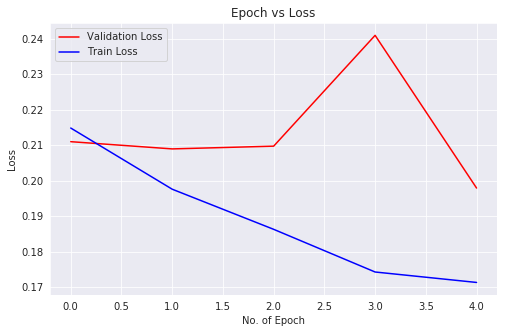

CPU times: user 22h 4min 57s, sys: 1d 5h 43min 55s, total: 2d 3h 48min 53s
Wall time: 2h 9min 56s


In [24]:
%time model, history = trainModel(model, x_train, y_train, optimizer, loss, nb_epoch, batch_size)
saveModel(model, 'model[lstm(100)]')

### [1.3] Model performance on test data:

In [28]:
local_summary=model_performance(x_test, y_test, nb_epoch, history, 'LSTM(100)')

48053/48053 [==============================] - 362s 8ms/step
Test score: 0.1934
Test accuracy: 0.9260


### [1.4]Model Summary:

In [29]:
print(local_summary)

+-----------+-----------+---------------+------------+----------------+----------+----------+
|   Model   | Test-Loss | Test-Accuracy | Train-Loss | Train-Accuracy | Val-Loss | Val-Accu |
+-----------+-----------+---------------+------------+----------------+----------+----------+
| LSTM(100) |   0.1934  |     0.9260    |   0.1713   |     0.9342     |  0.1979  |  0.9258  |
+-----------+-----------+---------------+------------+----------------+----------+----------+


## Model-2:

### [2.1]Model architecture:

In [32]:
#REFERENCE LINK: https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/
model = Sequential()
model.add(Embedding(vocab_size, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100, return_sequences=True, dropout=.5, recurrent_dropout=.5))
model.add(LSTM(50, dropout=.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 600, 32)           256000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 600, 100)          53200     
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 339,451
Trainable params: 339,451
Non-trainable params: 0
_________________________________________________________________


### [2.2]Train model on training data and draw loss plot:

Train on 78486 samples, validate on 33637 samples
Epoch 1/5
78486/78486 [==============================] - 2774s 35ms/step - loss: 0.2898 - acc: 0.8870 - val_loss: 0.2124 - val_acc: 0.9178
Epoch 2/5
78486/78486 [==============================] - 2779s 35ms/step - loss: 0.1987 - acc: 0.9223 - val_loss: 0.1980 - val_acc: 0.9241
Epoch 3/5
78486/78486 [==============================] - 2780s 35ms/step - loss: 0.1740 - acc: 0.9332 - val_loss: 0.1932 - val_acc: 0.9246
Epoch 4/5
78486/78486 [==============================] - 2806s 36ms/step - loss: 0.1614 - acc: 0.9380 - val_loss: 0.1923 - val_acc: 0.9248
Epoch 5/5
78486/78486 [==============================] - 2804s 36ms/step - loss: 0.1532 - acc: 0.9414 - val_loss: 0.2002 - val_acc: 0.9277


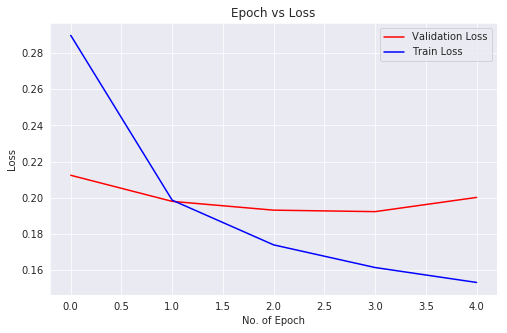

CPU times: user 1d 15h 15min 5s, sys: 2d 5h 25min 57s, total: 3d 20h 41min 2s
Wall time: 3h 52min 25s


In [35]:
%time model, history = trainModel(model, x_train, y_train, optimizer, loss, nb_epoch, batch_size)
saveModel(model, 'model[lstm(100)-lstm(50)]')

### [2.3] Model performance on test data:

In [37]:
local_summary=model_performance(x_test, y_test, nb_epoch, history, 'LSTM(100)->LSTM(50)')

48053/48053 [==============================] - 588s 12ms/step
Test score: 0.1962
Test accuracy: 0.9277


### [2.4] Model Summary:

In [38]:
print(local_summary)

+---------------------+-----------+---------------+------------+----------------+----------+----------+
|        Model        | Test-Loss | Test-Accuracy | Train-Loss | Train-Accuracy | Val-Loss | Val-Accu |
+---------------------+-----------+---------------+------------+----------------+----------+----------+
| LSTM(100)->LSTM(50) |   0.1962  |     0.9277    |   0.1532   |     0.9414     |  0.2002  |  0.9277  |
+---------------------+-----------+---------------+------------+----------------+----------+----------+


## Conclusion:
1. Performance with single LSTM with Dropout: 
        [a.] Loss : 0.1934
        [b.] Acc  : 0.9260
2. Performance with stacked LSTM with Dropout:
        [a.] Loss : 0.1962
        [b.] Acc  : 0.9277
#### Got optimal performance with Stacked LSTM. 

Reference Links:
1. http://appliedaicourse.com/ 
2. https://machinelearningmastery.com/save-load-keras-deep-learning-models/
3. https://machinelearningmastery.com/stacked-long-short-term-memory-networks/
4. https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/
5. https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/